## Part 1 ‐ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_json('logins.json')

In [3]:
df.dtypes

login_time    datetime64[ns]
dtype: object

In [4]:
df=df.sort_values(by='login_time')

In [5]:
df

login_time
6     1970-01-01 20:12:16
0     1970-01-01 20:13:18
1     1970-01-01 20:16:10
3     1970-01-01 20:16:36
2     1970-01-01 20:16:37
...                   ...
93136 1970-04-13 18:48:52
93137 1970-04-13 18:50:19
93139 1970-04-13 18:54:02
93141 1970-04-13 18:54:23
93140 1970-04-13 18:57:38

[93142 rows x 1 columns]

In [6]:
df['login']=1

In [7]:
df['weekday']=df['login_time'].dt.day_name()
df['week']=df['login_time'].dt.isocalendar().week
df['hour']=df['login_time'].dt.hour

df.head()

login_time  login   weekday  week  hour
6 1970-01-01 20:12:16      1  Thursday     1    20
0 1970-01-01 20:13:18      1  Thursday     1    20
1 1970-01-01 20:16:10      1  Thursday     1    20
3 1970-01-01 20:16:36      1  Thursday     1    20
2 1970-01-01 20:16:37      1  Thursday     1    20

In [8]:
df.set_index('login_time', inplace=True)
df.head()

login   weekday  week  hour
login_time                                      
1970-01-01 20:12:16      1  Thursday     1    20
1970-01-01 20:13:18      1  Thursday     1    20
1970-01-01 20:16:10      1  Thursday     1    20
1970-01-01 20:16:36      1  Thursday     1    20
1970-01-01 20:16:37      1  Thursday     1    20

Resample dataset on 15 min interval basis.

<class 'pandas.core.series.Series'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Series name: login
Non-Null Count  Dtype
--------------  -----
9788 non-null   int64
dtypes: int64(1)
memory usage: 152.9 KB


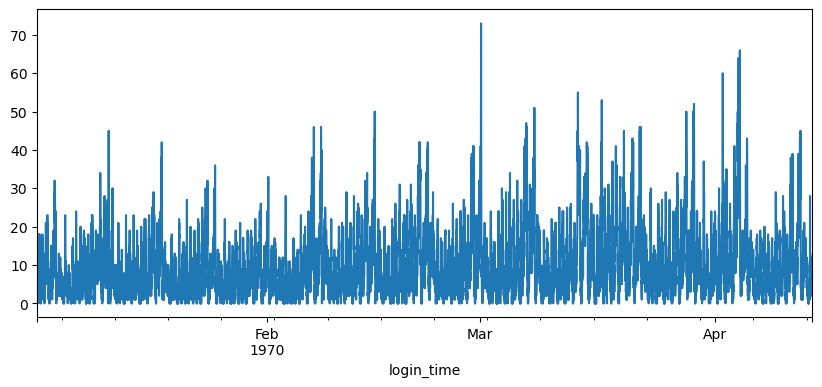

In [9]:
fig, ax=plt.subplots(figsize=(10, 4))
df1=df.resample('15min')['login'].sum()
df1.info()
df1.plot(ax=ax)
plt.show()

In [10]:
df1.describe()

count    9788.000000
mean        9.515938
std         8.328818
min         0.000000
25%         3.000000
50%         7.000000
75%        13.000000
max        73.000000
Name: login, dtype: float64

Let's check underlying trends and seasonality for week period for our df with 15 min intervals 4x24x7

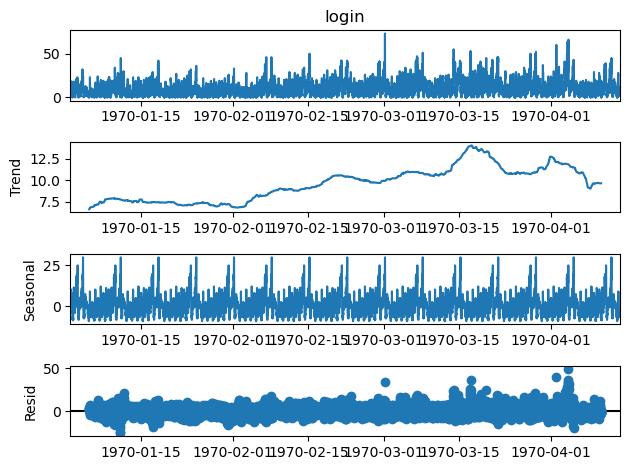

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompfreq=4*24*7
res = seasonal_decompose(df1, period=decompfreq)
res.plot()
plt.show()

There is seasonality in dataset, but no linear trend for given period.
Let's resample dataset on hourly basis and on daily one

Max number of logins during hour were 237  at  1970-04-04 01:00:00
Max number of logins during day were 1889  at  1970-04-04 00:00:00


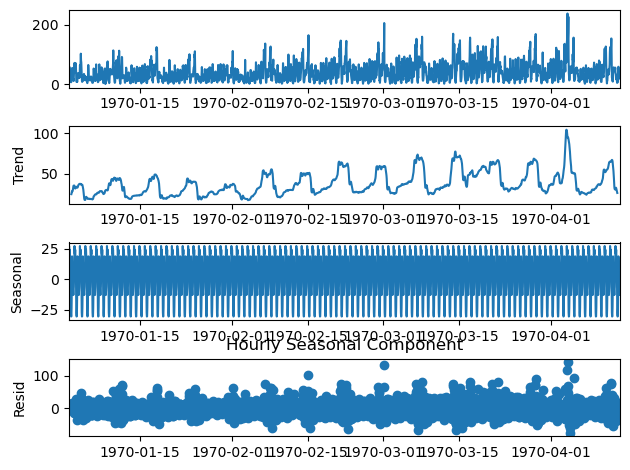

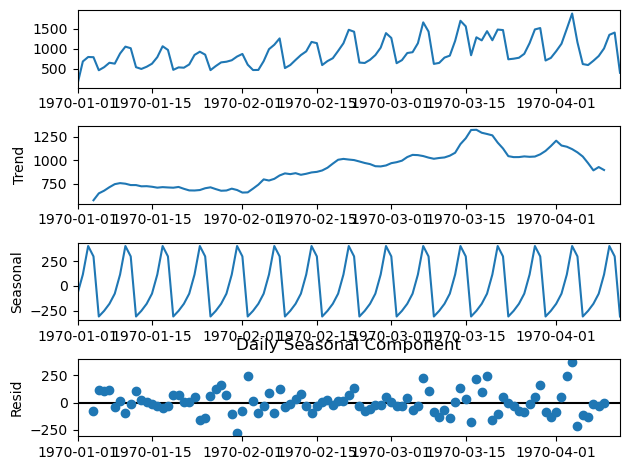

In [49]:
# Resample the data to hourly intervals to investigate daily seasonality
df_hourly = df.resample('H').agg(login=('login',np.sum))
print('Max number of logins during hour were',df_hourly.login.max(),' at ', df_hourly.login.idxmax())
# Resample the data to daily intervals to investigate weekly seasonality
df_daily = df.resample('D').agg(login=('login',np.sum))
print('Max number of logins during day were',df_daily.login.max(),' at ', df_daily.login.idxmax())

# Perform seasonal decomposition on the hourly data
decomp_hourly = seasonal_decompose(df_hourly, period=24)

# Perform seasonal decomposition on the daily data
decomp_daily = seasonal_decompose(df_daily, period=7)

# Plot the seasonal components for the hourly data
decomp_hourly.plot()
plt.title('Hourly Seasonal Component')
plt.show()

# Plot the seasonal components for the daily data
decomp_daily.plot()
plt.title('Daily Seasonal Component')
plt.show()

There is clear weekly seasonality in number of logins. Let's check ACF plots to find out time interval for seasonality

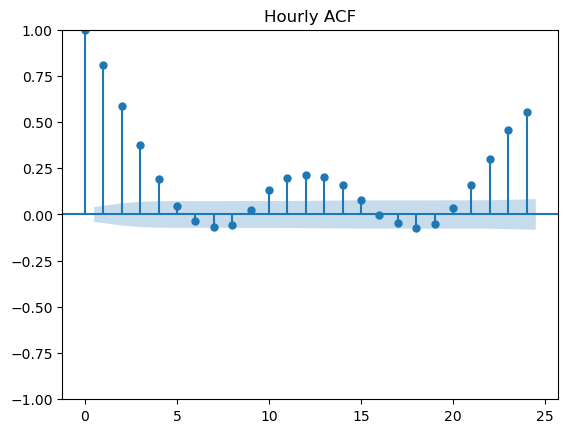

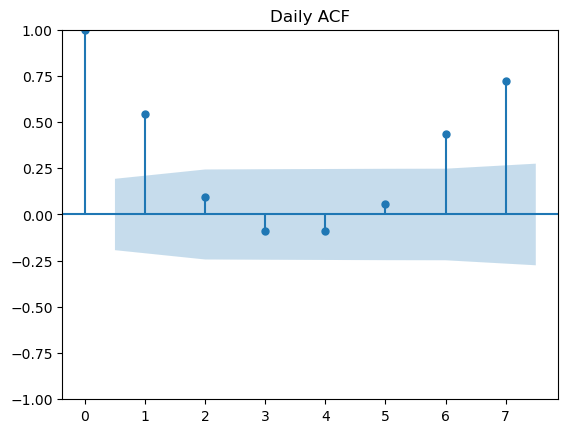

In [97]:
plot_acf(df_hourly, lags=24)
plt.title('Hourly ACF')
plt.show()

# Plot the ACF for the daily data
plot_acf(df_daily, lags=7)
plt.title('Daily ACF')
plt.show()

As we could see there is 12 hours seasonality in dataset as well as 7 days interval seasonality.

Let's count number of logins by weekdays and by hours during the day.

[]

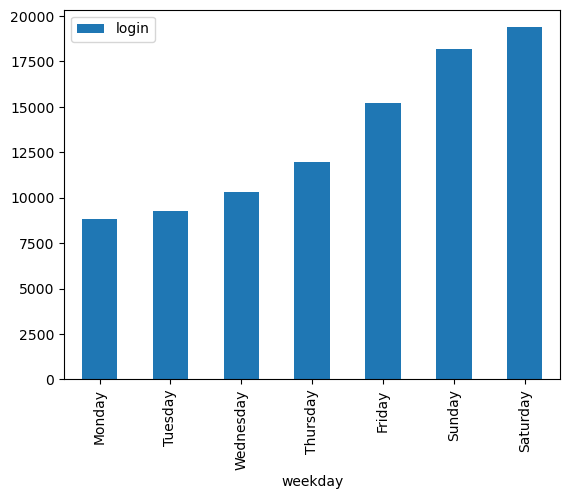

In [117]:
df_weekday=df.groupby('weekday').agg(login=('login', np.sum))
df_weekday.head()
df_weekday.sort_values(by=['login']).plot(kind='bar')
plt.plot()

In [37]:
df_weekly=df.resample('D').agg(login=('login',np.sum))
df_weekly['weekday']=df_weekly.index.day_name()
df_weekly.head()

login   weekday
login_time                 
1970-01-01    112  Thursday
1970-01-02    681    Friday
1970-01-03    793  Saturday
1970-01-04    788    Sunday
1970-01-05    459    Monday

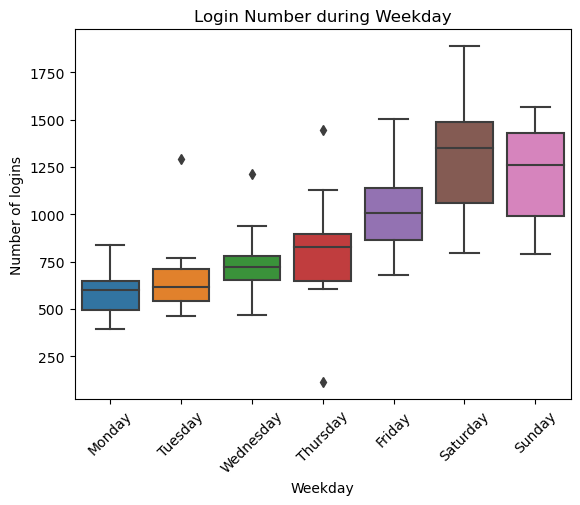

In [41]:
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.boxplot(x='weekday', y='login', data=df_weekly, order=order)
plt.title("Login Number during Weekday")
plt.xlabel("Weekday")
plt.ylabel("Number of logins")
plt.xticks(rotation=45)
plt.show();

Number of logins grows during the week till maximum on Saturday.

[]

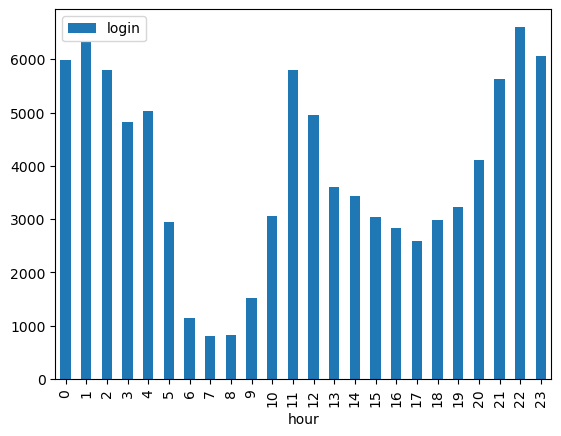

In [120]:
df_hour=df.groupby('hour').agg(login=('login', np.sum))
df_hour.head()
df_hour.plot(kind='bar')
plt.plot()

In [22]:
df_hourly['hour']=df_hourly.index.hour
df_hourly.head()

login  hour
login_time                      
1970-01-01 20:00:00     24    20
1970-01-01 21:00:00      9    21
1970-01-01 22:00:00     21    22
1970-01-01 23:00:00     58    23
1970-01-02 00:00:00     53     0

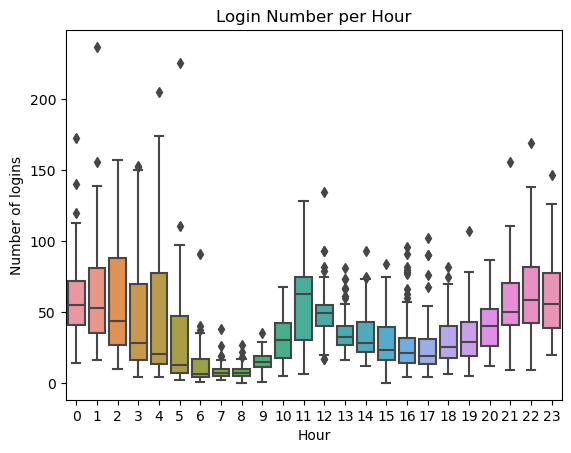

In [44]:
sns.boxplot(x='hour', y='login', data=df_hourly)
plt.title("Login Number per Hour")
plt.xlabel("Hour")
plt.ylabel("Number of logins")
plt.xticks(rotation=0)
plt.show();

Number of logins was high from 9PM to 3AM , the next peak is 11AM - 2PM.

### Summary
- The frequency of login activities exhibited an upward trend from January through March, with the highest count observed in March.
- Notably, a significant spike in logins was recorded on 1970-04-04, with a total of 1889 logins, predominantly occurring at 1AM (237 logins).
- The data indicates a higher incidence of logins during weekends compared to weekdays, with Saturday recording the highest number of logins and Sunday ranking second. Login patterns over the weekends exhibited greater variability than on weekdays.
- Login activities were predominantly concentrated during the night hours, between 9PM and 3AM, while the least number of logins were recorded in the morning hours. A secondary peak was observed during the hours of 11AM to 2PM.

## Part 2 ‐ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

### Answer
At this point of task we don't know the influence of encouraging driver partners to be available in both cities in relation to revenue growth, so what we can track is - number of bridge crossing through toll tracking information.

2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a) how you will implement the experiment
b) what statistical test(s) you will conduct to verify the significance of the observation
c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.
Note: The two cities of Gotham and Metropolis are not in the provided dataset; however, you do not need this information to answer Part 2.

### Answer
a) Experiment can be implemented next way - randomly selecting a group of drivers who currently only serve one city and offering them the toll cost reimbursement program.
Control group will be another group of driver partners who only serve one city would not be offered the program.
To implement the experiment, the city operations team could contact driver partners who only serve one city and ask if they would like to participate in the toll cost reimbursement program. The team could then randomly assign these driver partners to the experimental or control group.
Group sizes should be the same.
The experiment would run for a set period of time, such as one week or one month. Duration can be calculated depending on size of the groups and number of trips made by drivers.
b) A hypothesis test such as a t-test could be conducted to compare the mean number bridge crossing by driver partners in the experimental and control groups. The null hypothesis would be that there is no significant difference in the mean number of bridge crossing by driver partners between the two groups, while the alternative hypothesis would be that the mean number of bridge crossing by driver partners is significantly higher in the experimental group than in the control group.
If the p-value from the t-test is less than the chosen significance level, such as 0.05, the null hypothesis would be rejected, indicating that the toll cost reimbursement program was effective in increasing the number of bridge crossing by driver partners. If the p-value is greater than the significance level, the null hypothesis would be accepted, indicating that the program was not effective.
c) The results of the experiment could be interpreted as a recommendation to the city operations team to continue or discontinue the toll cost reimbursement program. However, there are some caveats to consider. The experiment would only involve a subset of driver partners and may not be representative of all driver partners in the two cities. Additionally, the experiment may not capture the long-term effects of the program, such as changes in driver behavior over time. These limitations should be acknowledged when interpreting the results and making recommendations.

## Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

Data description

city: city this user signed up in

phone: primary device for this user

signup_date: date of account registration; in the form ‘YYYYMMDD’

last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

avg_dist: the average distance in miles per trip taken in the first 30 days after signup

avg_rating_by_driver: the rider’s average rating over all of their trips

avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

surge_pct: the percent of trips taken with surge multiplier > 1

avg_surge: The average surge multiplier over all of this user’s trips

trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up

ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise

weekday_pct: the percent of the user’s trips occurring during a weekday

### Data Wrangling

In [50]:
ult_df=pd.read_json('ultimate_data_challenge.json')

In [52]:
ult_df.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   5.0  
1         50.0      8.26                   5.0  
2        100.0      0.77                   5.0  
3         80.0      2.36                   4.9  
4         82.4      3.13                   4.9

Let's check null values

In [51]:
ult_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


We have to remove lines with missing phone as it represents type of phone used by drivers and can influence on their retention.

avg_rating_of_driver and avg_rating_by_driver missing values can be filled with mean by dataset for these columns

In [53]:
ult_df['avg_rating_by_driver'].fillna(ult_df['avg_rating_by_driver'].mean(), inplace=True)
ult_df['avg_rating_of_driver'].fillna(ult_df['avg_rating_of_driver'].mean(), inplace=True)
ult_df.dropna(axis=0, inplace=True)

Change dates to datetime type

In [56]:
ult_df['last_trip_date'] = pd.to_datetime(ult_df['last_trip_date'], format='%Y%m%d')
ult_df['signup_date'] = pd.to_datetime(ult_df['signup_date'], format='%Y%m%d')

In [54]:
ult_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   signup_date             49604 non-null  object 
 3   avg_rating_of_driver    49604 non-null  float64
 4   avg_surge               49604 non-null  float64
 5   last_trip_date          49604 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               49604 non-null  float64
 8   ultimate_black_user     49604 non-null  bool   
 9   weekday_pct             49604 non-null  float64
 10  avg_dist                49604 non-null  float64
 11  avg_rating_by_driver    49604 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [63]:
ult_df.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'active_user'],
      dtype='object')

Calculate the cutoff date for determining active users and create new column for active users

In [68]:
from datetime import timedelta
cutoff_date = ult_df['last_trip_date'].max() - timedelta(days=30)
ult_df['active_user'] = (ult_df['last_trip_date'] >= cutoff_date).astype(int)
print(round(len(ult_df[ult_df['active_user']==1])/len(ult_df['active_user']),2)*100,'% of the observed users were retained')


38.0 % of the observed users were retained


In [69]:
#change bool type to int in ultimate_black_user column
ult_df['ultimate_black_user']=ult_df['ultimate_black_user'].astype(int)

### Exploratory analysis

In [95]:
categorical_values=['city', 'phone',
       'ultimate_black_user']
numerical_values=['trips_in_first_30_days', 'avg_rating_of_driver',
       'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver']

In [86]:
ult_df[numerical_values].describe(percentiles=[0.25, 0.5, 0.75, 0.95])

trips_in_first_30_days  avg_rating_of_driver     avg_surge  \
count            49604.000000          49604.000000  49604.000000   
mean                 2.277256              4.601482      1.074991   
std                  3.793300              0.565227      0.222666   
min                  0.000000              1.000000      1.000000   
25%                  0.000000              4.500000      1.000000   
50%                  1.000000              4.700000      1.000000   
75%                  3.000000              5.000000      1.050000   
95%                  9.000000              5.000000      1.380000   
max                125.000000              5.000000      8.000000   

          surge_pct   weekday_pct      avg_dist  avg_rating_by_driver  
count  49604.000000  49604.000000  49604.000000          49604.000000  
mean       8.875314     60.883832      5.785418              4.777862  
std       19.989018     37.086239      5.669709              0.446220  
min        0.000000      0.000000      0.000000              1.000000  
25%        0.000000     33.300000      2.420000              4.700000  
50%        0.000000     66.700000      3.880000              5.000000  
75%        8.700000    100.000000      6.930000              5.000000  
95%       50.000000    100.000000     16.727000              5.000000  
max      100.000000    100.000000    160.960000              5.000000

#### Numerical values analysis

Let's check histogram plots for numerical columns

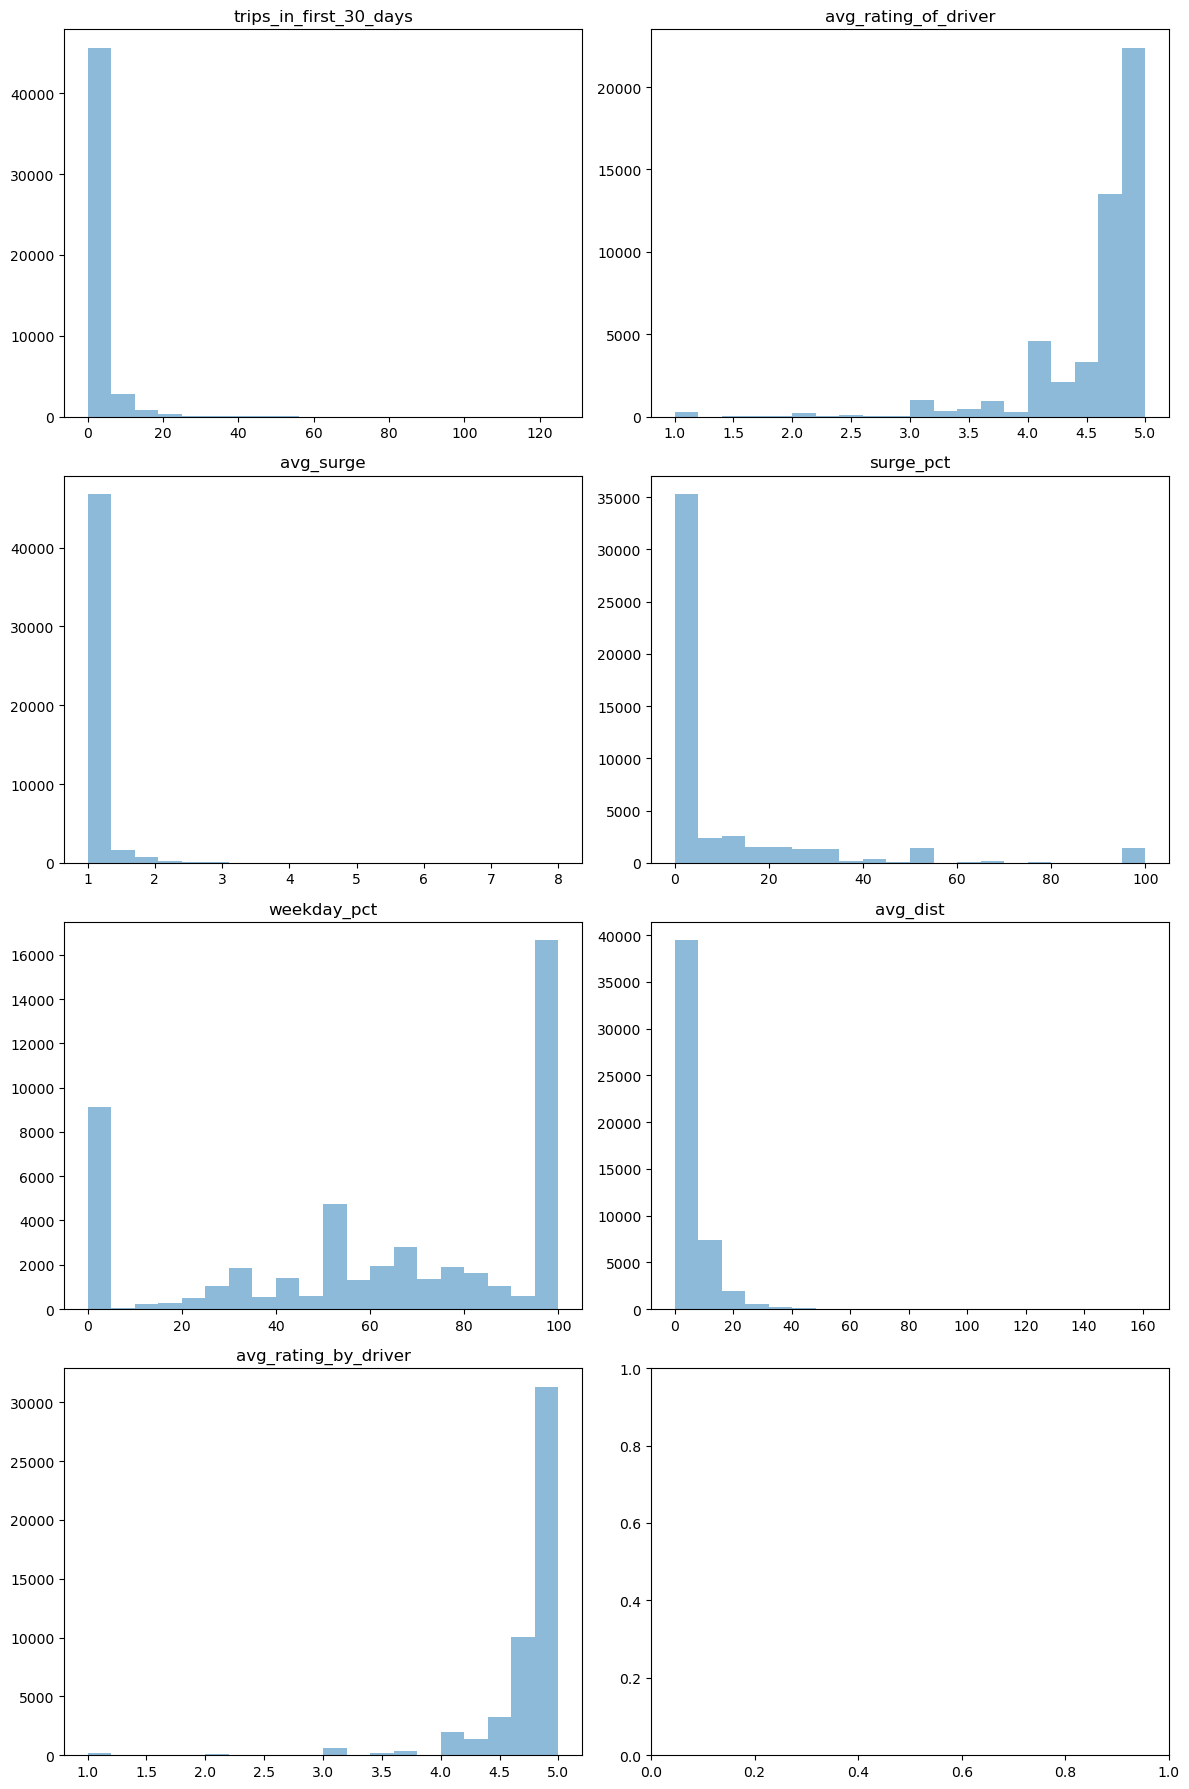

In [79]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 18))
for ax, val in zip(axes.flatten(), numerical_values):
    ax.hist(ult_df[val], bins=20, alpha=0.5)
    ax.set_title(val)
    
plt.tight_layout()
plt.show()

Let's check distribution for active and inactive users

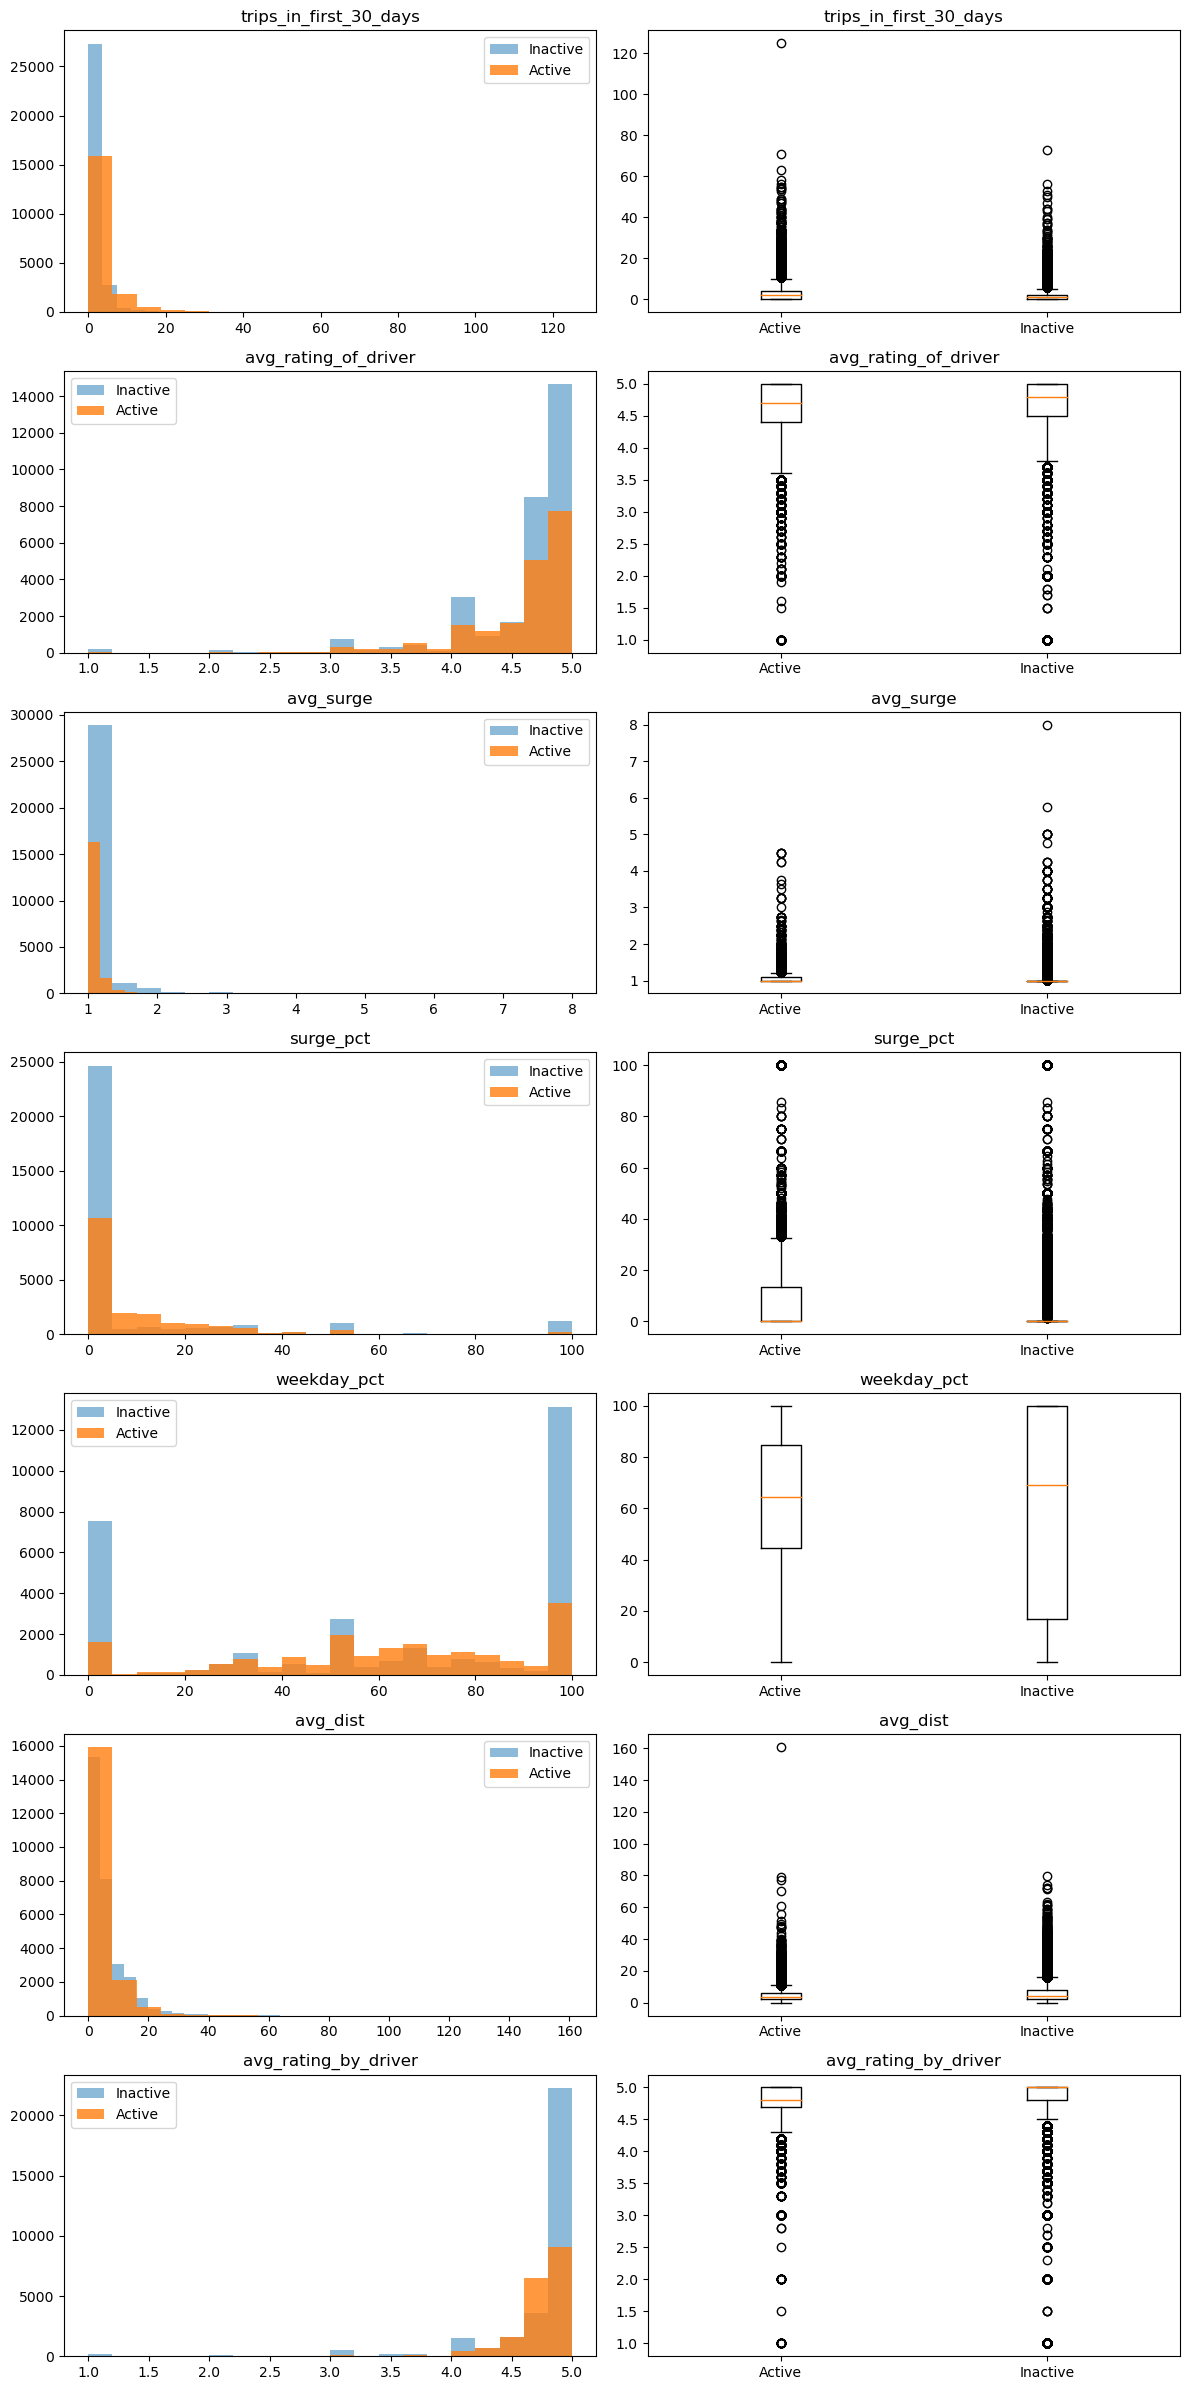

In [89]:
def plot_num(ult_df):
    # Create a DataFrame for active users
    active_df = ult_df[ult_df['active_user'] == 1]

    # Create a DataFrame for inactive users
    inactive_df = ult_df[ult_df['active_user'] == 0]
    # Create a figure with subplots for each column
    fig, axs = plt.subplots(nrows=len(numerical_values), ncols=2, figsize=(12, 24))

    # Loop through each column and plot a histogram for active and inactive users
    for i, col in enumerate(numerical_values):
        axs[i, 0].hist(inactive_df[col], bins=20, alpha=0.5, label='Inactive')
        axs[i, 0].hist(active_df[col], bins=20, alpha=0.8, label='Active')
        axs[i, 0].set_title(col)
        axs[i, 0].legend()

        # Plot a boxplot for each column
        axs[i, 1].boxplot([active_df[col], inactive_df[col]], labels=['Active', 'Inactive'])
        axs[i, 1].set_title(col)

    # Adjust the layout of the subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_num(ult_df)

As we can see all columns have pretty similar distributions for active and inactive users.

Almost all columns have long tails of outliers.

weekend_pct column values varies the most for both types of users where big parts of them have 100% of their trips over weekends and second biggest part of them have 0% of such trips.

We need to address ouliers before modeling. Let's check trimming technique and leave only data for 0.95 percentile.

       trips_in_first_30_days  avg_rating_of_driver     avg_surge  \
count            49604.000000          49604.000000  49604.000000   
mean                 2.237118              4.601482      1.070868   
std                  3.428656              0.565227      0.185065   
min                  0.000000              1.000000      1.000000   
25%                  0.000000              4.500000      1.000000   
50%                  1.000000              4.700000      1.000000   
75%                  3.000000              5.000000      1.050000   
95%                  9.000000              5.000000      1.380000   
max                 24.000000              5.000000      2.300000   

          surge_pct   weekday_pct      avg_dist  avg_rating_by_driver  
count  49604.000000  49604.000000  49604.000000          49604.000000  
mean       8.875314     60.883832      5.763343              4.784033  
std       19.989018     37.086239      5.473766              0.402669  
min        0.000000  

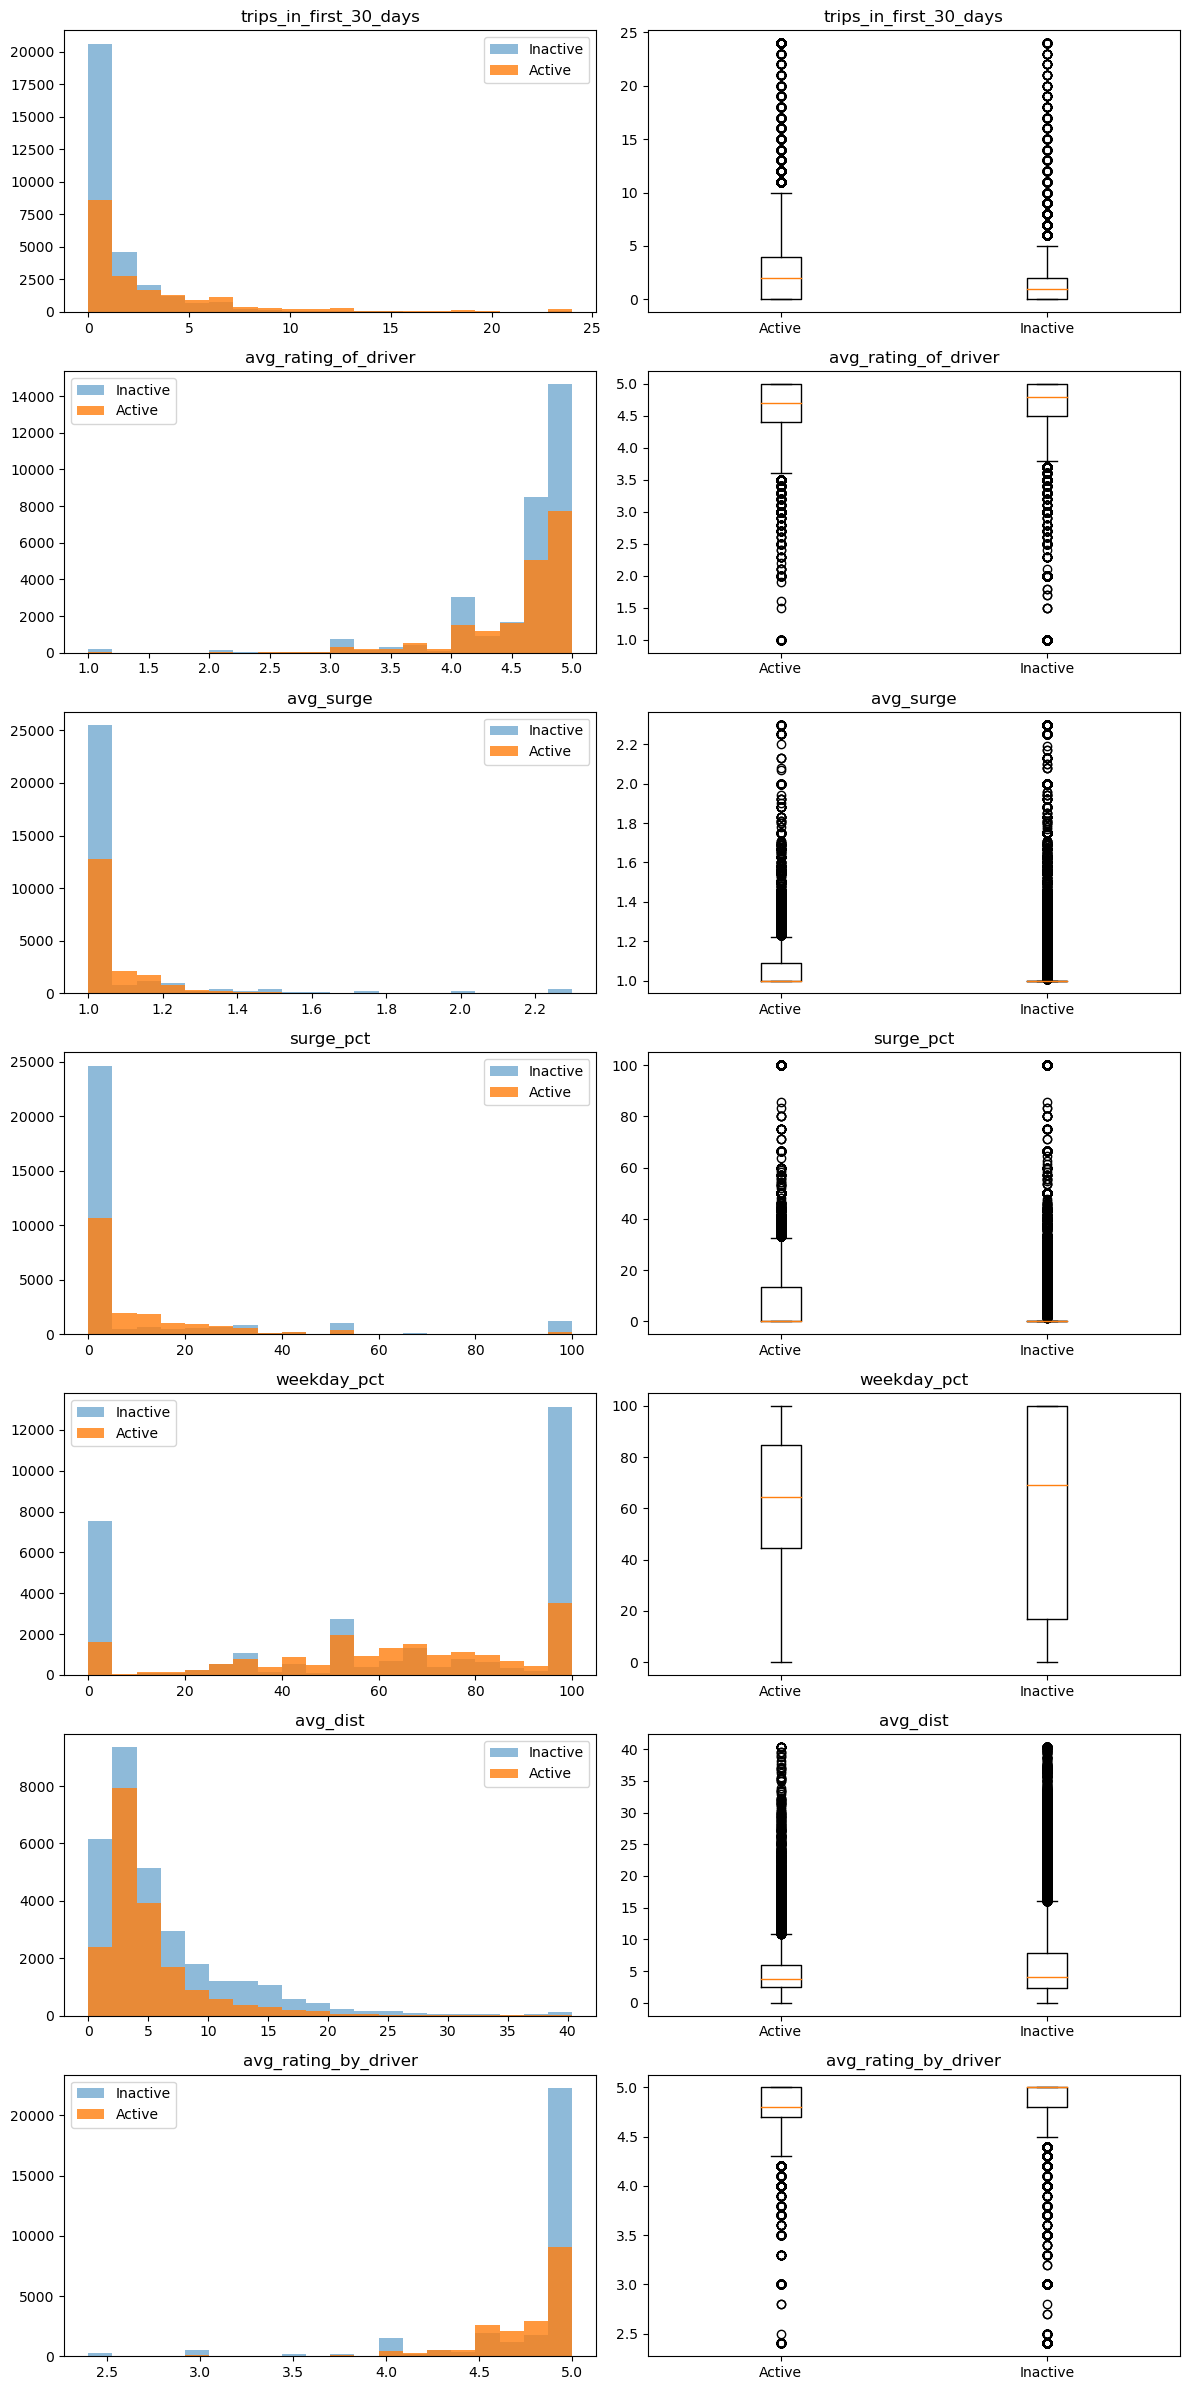

In [111]:
# compute the 2.5th and 97.5th percentiles for each column
Q25 = ult_df[numerical_values].quantile(0.025)
Q975 = ult_df[numerical_values].quantile(0.975)

# compute the interquartile range (IQR) for each column
IQR = Q975 - Q25

# define the lower and upper bounds for outliers
lower_bound = Q25-IQR
upper_bound = Q975 + IQR

# create a copy of the original data frame to store the trimmed data
trimmed_df = ult_df.copy()

# trim the outliers for each column
for col in numerical_values:
    trimmed_df[col] = np.clip(trimmed_df[col], lower_bound[col], upper_bound[col])
print(trimmed_df[numerical_values].describe(percentiles=[0.25, 0.5, 0.75, 0.95]))
# check the distribution of each column after trimming outliers
plot_num(trimmed_df)

Let's check scatterplots for numerical columns

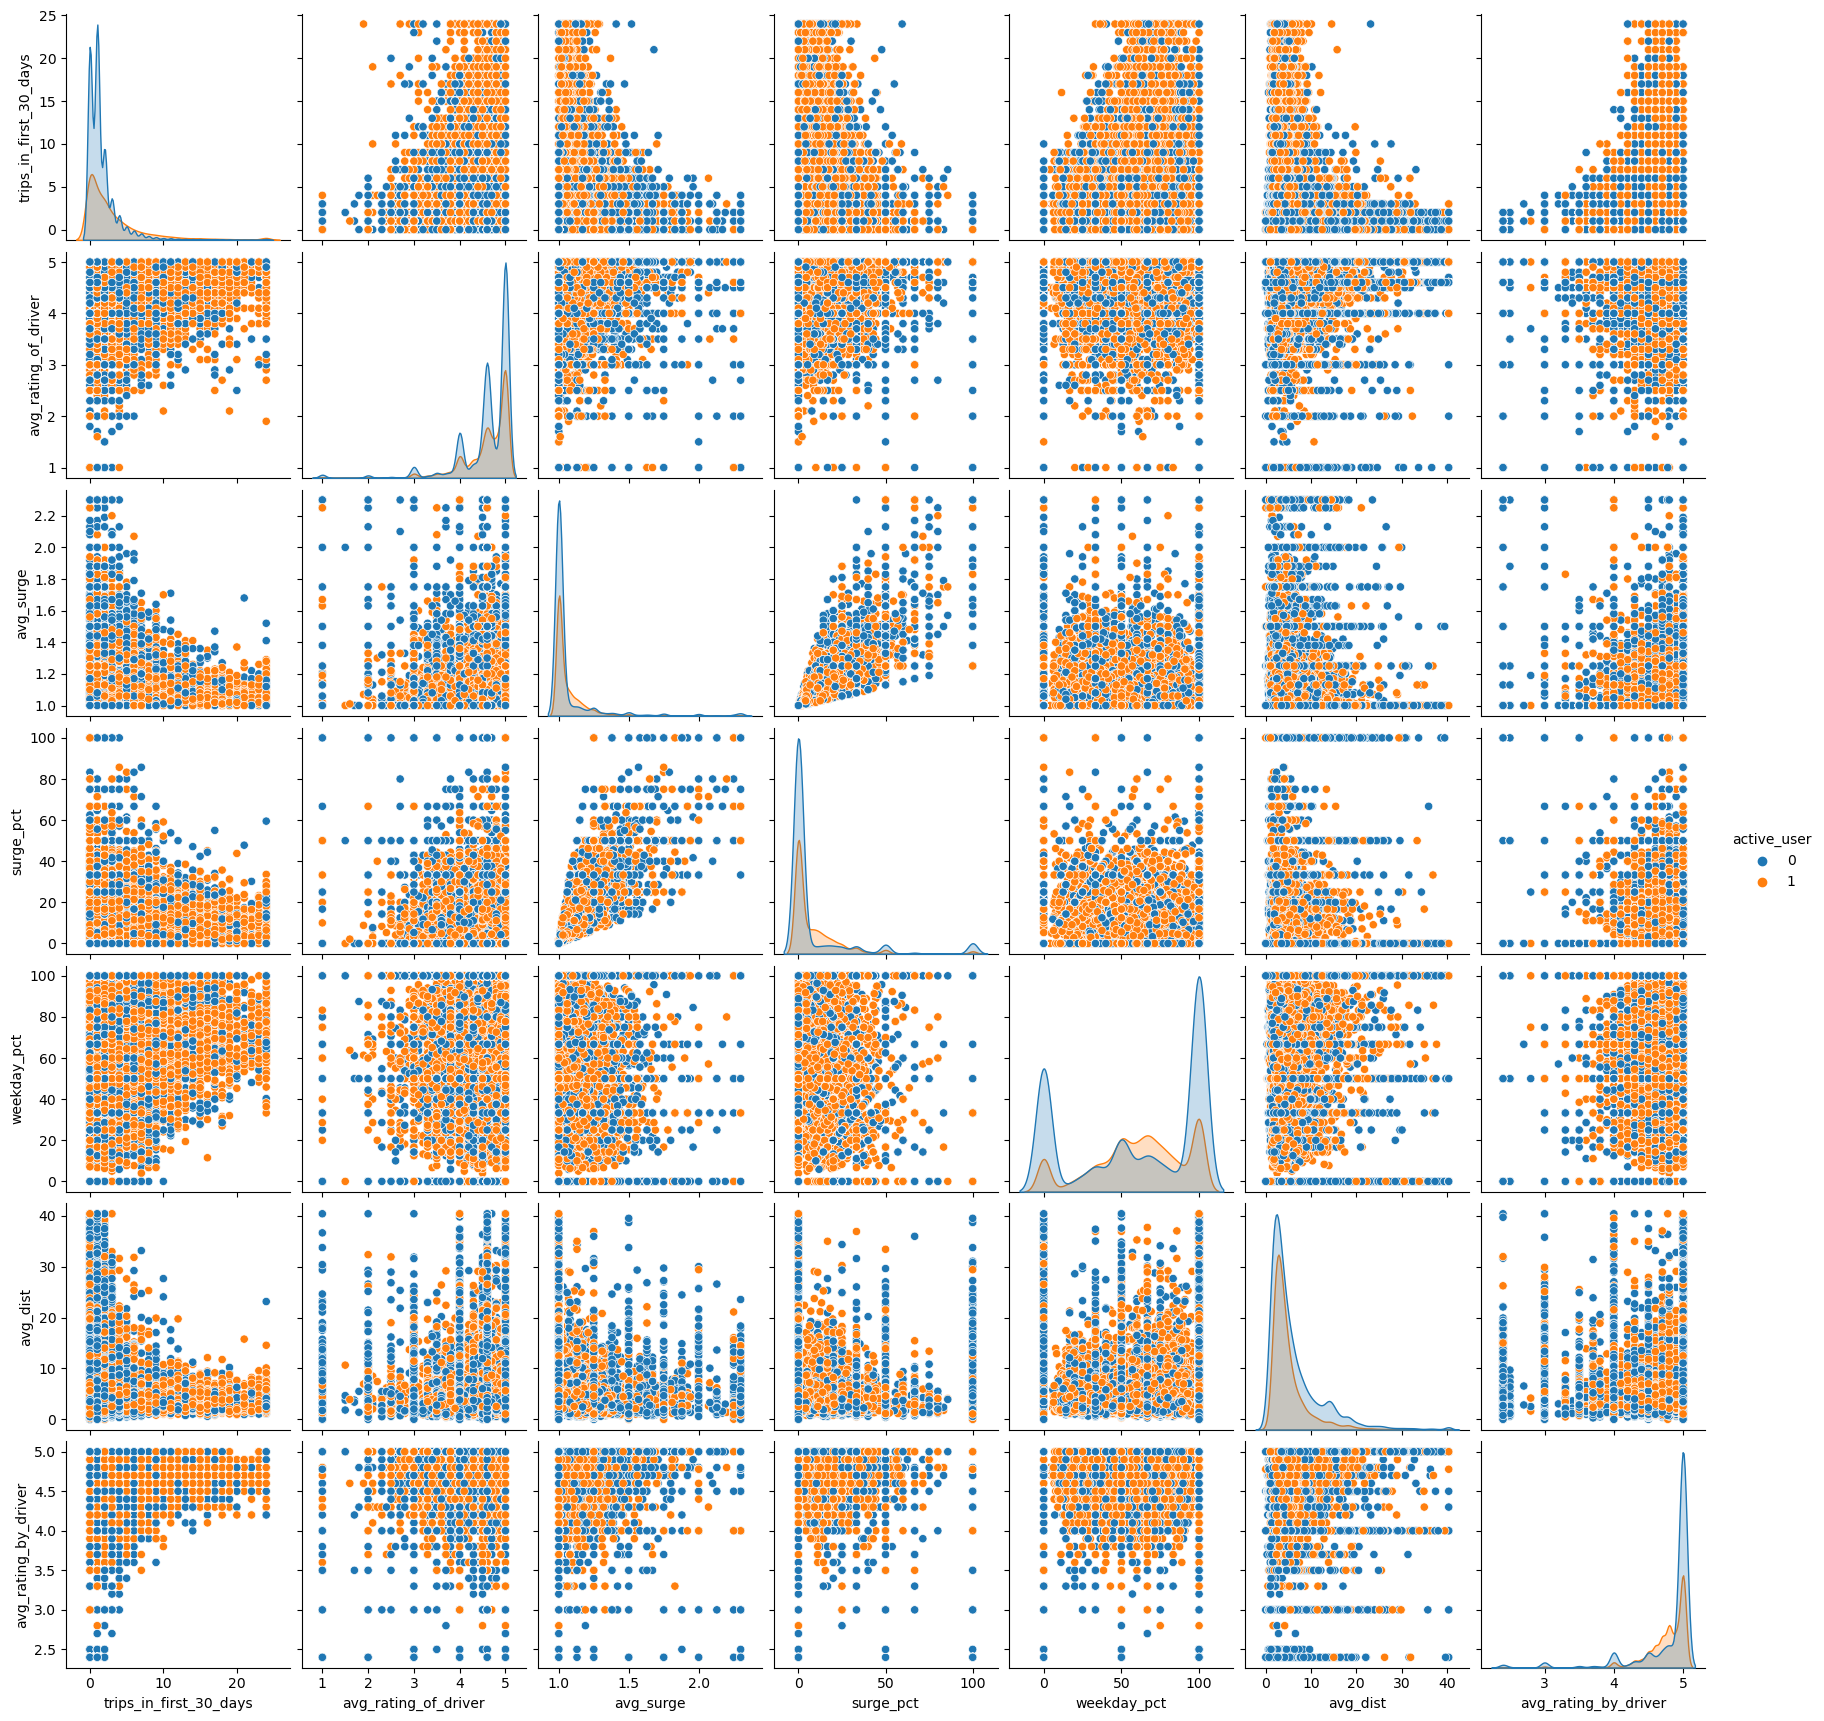

In [112]:
_=sns.pairplot(trimmed_df.drop(categorical_values, axis=1), hue='active_user')

#### Correlation heatmap

Let's check correlation between numerical columns

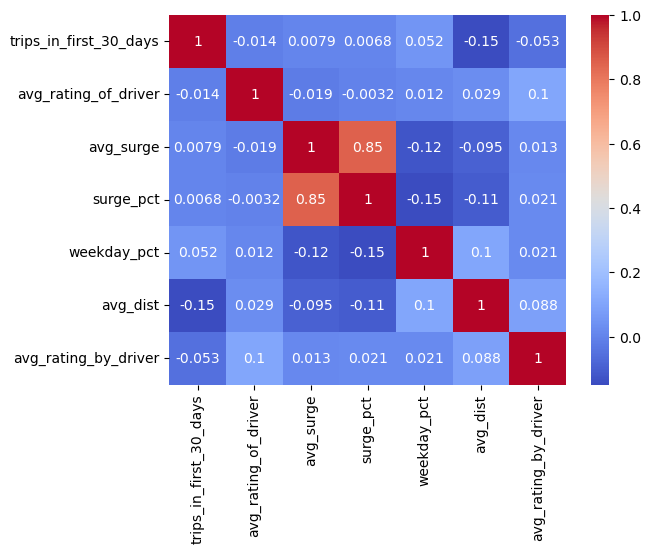

In [113]:
corr_matrix = trimmed_df[numerical_values].corr()

# Create the heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True);

#### Categorical values. Bi-variate analysis

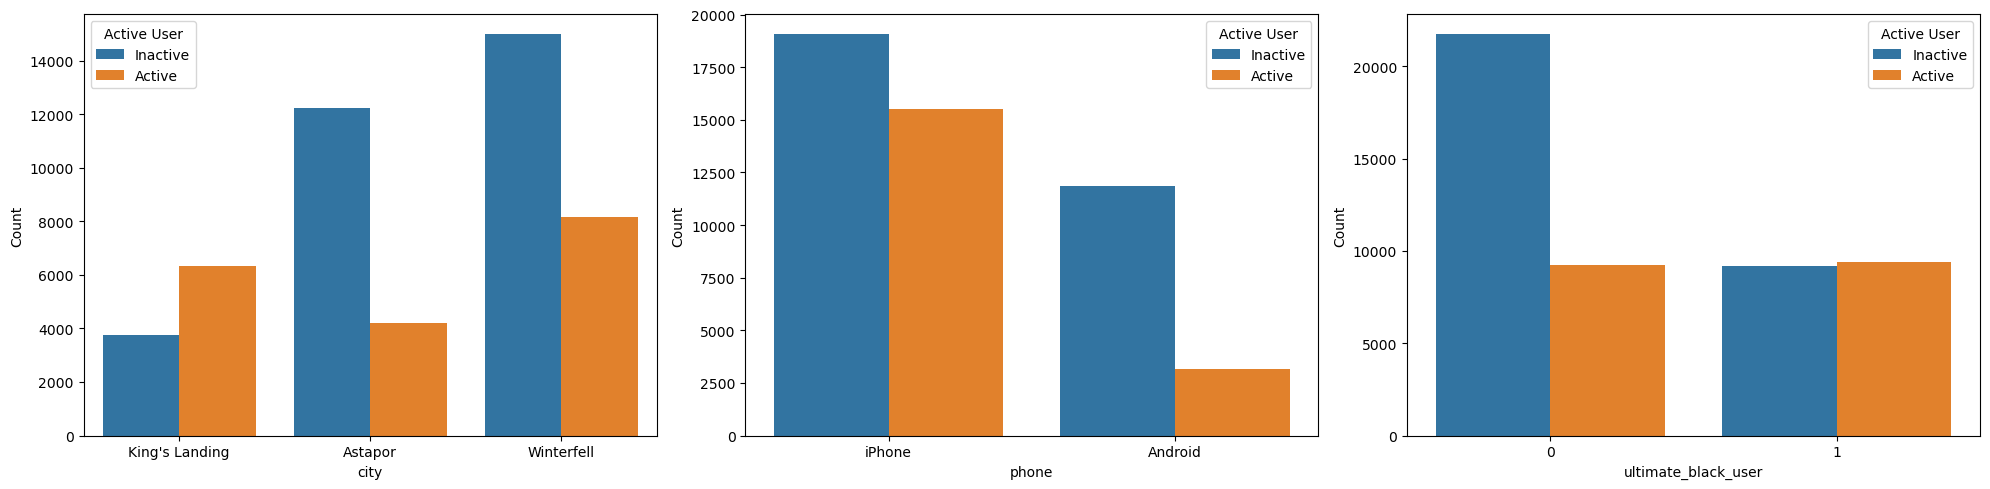

In [99]:
fig, axes = plt.subplots(nrows=1, ncols=len(categorical_values), figsize=(20,5))

for i, col in enumerate(categorical_values):
    sns.countplot(x=col, hue='active_user', data=trimmed_df, ax=axes[i])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].legend(title='Active User', labels=['Inactive', 'Active'])

plt.tight_layout()
plt.show()

- Most of inactive users are from Wintefell city and in percentage value most of Astapor city users became inactive
- Most of inactive users are iPhone users but by percentage more Android became inactive
- Most of inactive users didn't use ultimate black during first 30 days.

### Data preprocessing

In [101]:
# Creating dummy variables for categorical features
trimmed_df = pd.get_dummies(trimmed_df, columns = ['city', 'phone', 'ultimate_black_user'], drop_first=True)

In [103]:
#drop dates columns
trimmed_df.drop(['signup_date', 'last_trip_date'], axis=1, inplace=True)
trimmed_df.head()

trips_in_first_30_days  avg_rating_of_driver  avg_surge  surge_pct  \
0                       4                   4.7       1.10       15.4   
1                       0                   5.0       1.00        0.0   
2                       3                   4.3       1.00        0.0   
3                       9                   4.6       1.14       20.0   
4                      14                   4.4       1.19       11.8   

   weekday_pct  avg_dist  avg_rating_by_driver  active_user  \
0         46.2      3.67                   5.0            1   
1         50.0      8.26                   5.0            0   
2        100.0      0.77                   5.0            0   
3         80.0      2.36                   4.9            1   
4         82.4      3.13                   4.9            0   

   city_King's Landing  city_Winterfell  phone_iPhone  ultimate_black_user_1  
0                    1                0             1                      1  
1                    0                0             0                      0  
2                    0                0             1                      0  
3                    1                0             1                      1  
4                    0                1             0                      0

#### Split data

In [104]:
X = trimmed_df.drop('active_user', axis=1)
y = trimmed_df['active_user']

In [116]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
X_train.head()

(39683, 11) (39683,)
(9921, 11) (9921,)


trips_in_first_30_days  avg_rating_of_driver  avg_surge  surge_pct  \
19651                       5              5.000000        1.0        0.0   
22378                       3              5.000000        1.0        0.0   
23224                       1              4.000000        1.0        0.0   
7796                        7              4.000000        1.0        0.0   
14025                       0              4.601559        1.0        0.0   

       weekday_pct  avg_dist  avg_rating_by_driver  city_King's Landing  \
19651          0.0      2.04                   5.0                    0   
22378         66.7      4.50                   5.0                    0   
23224        100.0     15.88                   5.0                    0   
7796          75.0      7.56                   4.5                    0   
14025        100.0     31.59                   5.0                    1   

       city_Winterfell  phone_iPhone  ultimate_black_user_1  
19651                0             0                      1  
22378                1             1                      0  
23224                0             0                      0  
7796                 1             1                      1  
14025                0             0                      0

#### Scale data

As we could see during EDA our numerical features don't follow normal distribution and have long tails of outliers, so we have to use MinMaxScaler in this case

In [118]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Create a scaler object
scaler = StandardScaler()

# Normalize the numerical columns
X_train[numerical_values] = scaler.fit_transform(X_train[numerical_values])
X_test[numerical_values] = scaler.transform(X_test[numerical_values])
X_train.head()

trips_in_first_30_days  avg_rating_of_driver  avg_surge  surge_pct  \
19651                0.795818              0.702494  -0.381191  -0.442503   
22378                0.216339              0.702494  -0.381191  -0.442503   
23224               -0.363140             -1.055324  -0.381191  -0.442503   
7796                 1.375296             -1.055324  -0.381191  -0.442503   
14025               -0.652879              0.002108  -0.381191  -0.442503   

       weekday_pct  avg_dist  avg_rating_by_driver  city_King's Landing  \
19651    -1.643761 -0.676784              0.536717                    0   
22378     0.154996 -0.229958              0.536717                    0   
23224     1.053026  1.837066              0.536717                    0   
7796      0.378830  0.325850             -0.705828                    0   
14025     1.053026  4.690577              0.536717                    1   

       city_Winterfell  phone_iPhone  ultimate_black_user_1  
19651                0             0                      1  
22378                1             1                      0  
23224                0             0                      0  
7796                 1             1                      1  
14025                0             0                      0

### Modeling

We will use next models for our classification task:
'Logistic Regression', 
'Random Forest', 
'Gradient Boosting', 
'Support Vector Machine', 
'Naive Bayes'

In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, classification_report
import time

In [122]:
# Define the models
models = [
    {'name': 'Logistic Regression', 'estimator': LogisticRegression(), 'params': {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}},
    {'name': 'Random Forest', 'estimator': RandomForestClassifier(), 'params': {'n_estimators': [10, 50, 100], 'max_depth': [5, 10, 20, None], 'min_samples_split': [2, 5, 10], 'criterion': ["gini", "entropy"]}},
    {'name': 'Gradient Boosting', 'estimator': GradientBoostingClassifier(), 'params': {'n_estimators': [10, 50, 100], 'max_depth': [5, 10, 20, None], 'learning_rate': [0.01, 0.1, 1]}},
    {'name': 'SVM', 'estimator': SVC(), 'params': {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'kernel': ['linear', 'poly', 'rbf'], 'degree': [2, 3]}},
    {'name': 'Naive Bayes', 'estimator': GaussianNB(), 'params': {'var_smoothing': [1e-09, 1e-08, 1e-07]}}
]

In [126]:
# Iterate over the models
for model in models:
    print(f"Running {model['name']} model...")
    estimator = model['estimator']
    params = model['params']
    start_time = time.time()
    clf = GridSearchCV(estimator, params, cv=5, scoring='f1')
    clf.fit(X_train, y_train)
    
    end_time = time.time()
    print(f"{model['name']} trained in {round(end_time-start_time, 2)} seconds.")
    print("Best parameters:", clf.best_params_)
    print("Best score:", clf.best_score_)
    
    # predict on test set and print classification report
    y_pred = clf.predict(X_test)
    print(f"\nClassification Report for {model['name']}:")
    print(classification_report(y_test, y_pred))
    print("-------------------------------------------------------\n")

Running Logistic Regression model...


/Users/klynete/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/klynete/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/klynete/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/klynete/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py

Logistic Regression trained in 1.24 seconds.
Best parameters: {'C': 1, 'penalty': 'l2'}
Best score: 0.57409073825443

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.74      0.85      0.79      6200
           1       0.66      0.49      0.56      3721

    accuracy                           0.71      9921
   macro avg       0.70      0.67      0.68      9921
weighted avg       0.71      0.71      0.70      9921

-------------------------------------------------------

Running Random Forest model...
Random Forest trained in 342.93 seconds.
Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best score: 0.6937410444265187

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      6200
           1       0.74      0.66      0.69      3721

    accuracy                          

In [128]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the model with the specified hyperparameters
model = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, n_estimators=100, random_state=42)

# Fit the model to the training data
start_time = time.time()
model.fit(X_train, y_train)
training_time = time.time() - start_time

# Make predictions on the training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate the model on the F1 score
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

# Evaluate the model on accuracy
acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

# Compute feature importance on training data
importances = model.feature_importances_

# Print confusion matrix and classification report
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_test_pred))
print('\nClassification Report:')
print(classification_report(y_test, y_test_pred))

print(f"Training time: {training_time:.2f}s")
print(f"F1 score on train set: {f1_train:.4f}")
print(f"F1 score on test set: {f1_test:.4f}")
print(f"Accuracy on train set: {acc_train:.4f}")
print(f"Accuracy on test set: {acc_test:.4f}")
print(f"Feature importance: {importances}")

Confusion Matrix:
[[5330  870]
 [1213 2508]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.84      6200
           1       0.74      0.67      0.71      3721

    accuracy                           0.79      9921
   macro avg       0.78      0.77      0.77      9921
weighted avg       0.79      0.79      0.79      9921

Training time: 4.00s
F1 score on train set: 0.7256
F1 score on test set: 0.7066
Accuracy on train set: 0.8041
Accuracy on test set: 0.7900
Feature importance: [0.05272018 0.01711596 0.01425569 0.15260312 0.12456598 0.03332974
 0.27954224 0.16306462 0.01371103 0.08507744 0.06401399]


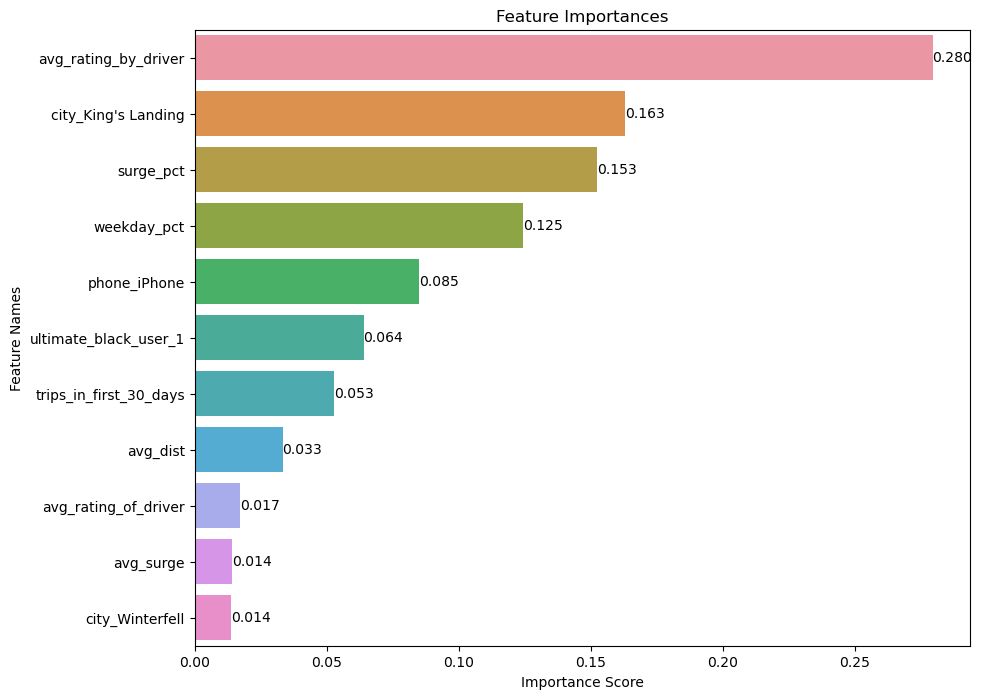

In [129]:
feature_importances = importances
feature_names = X_train.columns

# Create a dataframe of feature importances
fi_df = pd.DataFrame({'feature_names': feature_names, 'importance_scores': feature_importances})
fi_df = fi_df.sort_values(by='importance_scores', ascending=False).reset_index()

# Create a horizontal bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x='importance_scores', y='feature_names', data=fi_df)

# Annotate the importance scores on the plot
for index, row in fi_df.iterrows():
    plt.text(row['importance_scores'], index, '{:.3f}'.format(row['importance_scores']), va='center')

plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature Names')
plt.show()

In [132]:
fi_df.drop('index', axis=1).head()

feature_names  importance_scores
0  avg_rating_by_driver           0.279542
1   city_King's Landing           0.163065
2             surge_pct           0.152603
3           weekday_pct           0.124566
4          phone_iPhone           0.085077

## Summary 

I had conducted a grid search using the models Logistic Regression, Random Forest, Gradient Boosting, Support Vector Machine, and Naive Bayes. The F1 score was used as the metric and the best model was found to be Gradient Boosting with the hyperparameters learning_rate=0.1, max_depth=5, and n_estimators=100 with a random state of 42.

In addition to the model performance, we analyzed the feature importance and found that the top 5 most important features for the model were:

- Average rating by driver
- City (King's Landing)
- Surge percentage
- Weekday percentage
- Phone (iPhone)

These features could potentially provide insights for Ultimate to improve long-term rider retention. For example, improving the surge pricing strategy, targeting iPhone users with promotions, and enhancing the weekday ride experience could all potentially lead to increased retention.

Overall, the model appears to be valid with a decent F1 score and significant feature importance. However, it is important to continuously monitor and evaluate the model's performance and adjust as needed.